In [1]:
import numpy as np
from scipy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
# Parameters
Nsteps = 1000
N = 256
dt = 0.0001
dx = 0.1
L = N * dx
M = 1.0
kappa = 0.001
W = 0.1

# Initialize arrays
c = 0.5 * np.random.rand(N, N)
c0 = np.mean(c)
print('Initial average concentration c0 = ', c0)
c_history = [c.copy()]  # Store initial condition

c_k = fft2(c)
prev_steps = []

# Wavenumbers
kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(N, d=dx) * 2 * np.pi
K = np.array(np.meshgrid(kx, ky))
K2 = np.sum(K * K, axis=0)


Initial average concentration c0 =  0.4988207004038459


## Using RK4 for first four time steps (Explicit method)

You can adapt the RK4 scheme to solve the Cahn-Hilliard equation. For the RHS defined as:

$$
\text{RHS} =M[-\kappa k^4\widehat{c}_{\boldsymbol{k}}^n-k^2\mathcal {FT}\{\frac{\delta f}{\delta c}\}]
$$

The RK4 scheme becomes:

$$
k_1 = \Delta t * RHS(\hat{c}_{\boldsymbol{k}}^n)
$$
$$
k_2 = \Delta t * RHS(\hat{c}_{\boldsymbol{k}}^n + k_1 / 2)
$$
$$
k_3 = \Delta t * RHS(\hat{c}_{\boldsymbol{k}}^n + k_2 / 2)
$$
$$
k_4 = \Delta t * RHS(\hat{c}_{\boldsymbol{k}}^n + k_3)
$$
$$
\hat{c}_{\boldsymbol{k}}^{n+1} = \hat{c}_{\boldsymbol{k}}^n + (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6
$$


## The fourth-order Adams-Moulton method for subsequent time steps (Implict method)

To adapt this for the Cahn-Hilliard equation in Fourier space, we can use:

$$
\text{RHS}(\hat{c}) = M[-\kappa k^4 \hat{c}_{\boldsymbol{k}}^n - k^2 \mathcal{FT}\{f'(c)\}]
$$

And the adapted Adams-Moulton formula becomes:

$$
\hat{c}_{\boldsymbol{k}}^{n+4} = \hat{c}_{\boldsymbol{k}}^{n+3} + \frac{\Delta t}{720} \left[ 251 \text{RHS}(\hat{c}_{\boldsymbol{k}}^{n+4}) + 646 \text{RHS}(\hat{c}_{\boldsymbol{k}}^{n+3}) - 264 \text{RHS}(\hat{c}_{\boldsymbol{k}}^{n+2}) + 106 \text{RHS}(\hat{c}_{\boldsymbol{k}}^{n+1}) - 19 \text{RHS}(\hat{c}_{\boldsymbol{k}}^n) \right]
$$


We want to isolate $\hat{c}_{\boldsymbol{k}}^{n+4}$ from the equation 


## Isolating $\hat{c}_{\boldsymbol{k}}^{n+4}$ from the Adams-Moulton Equation



To isolate $\hat{c}_{\boldsymbol{k}}^{n+4}$, we can rewrite the equation as follows:
$$
\hat{c}_{\boldsymbol{k}}^{n+4} \left( 1 - \frac{251 \Delta t M \kappa k^4}{720} \right) = \hat{c}_{\boldsymbol{k}}^{n+3} + \frac{\Delta t}{720} \left( 646 \text{RHS}(\hat{c}_{\boldsymbol{k}}^{n+3}) - 264 \text{RHS}(\hat{c}_{\boldsymbol{k}}^{n+2}) + 106 \text{RHS}(\hat{c}_{\boldsymbol{k}}^{n+1}) - 19 \text{RHS}(\hat{c}_{\boldsymbol{k}}^n) \right)
$$

Finally, isolating $\hat{c}_{\boldsymbol{k}}^{n+4}$ gives:

$$
\hat{c}_{\boldsymbol{k}}^{n+4} = \frac{\hat{c}_{\boldsymbol{k}}^{n+3} + \frac{\Delta t}{720} \left( 646 \text{RHS}(\hat{c}_{\boldsymbol{k}}^{n+3}) - 264 \text{RHS}(\hat{c}_{\boldsymbol{k}}^{n+2}) + 106 \text{RHS}(\hat{c}_{\boldsymbol{k}}^{n+1}) - 19 \text{RHS}(\hat{c}_{\boldsymbol{k}}^n) \right)}{1 - \frac{251 \Delta t M \kappa k^4}{720}}
$$

1. **Inverse Fourier Transform**:Take the inverse Fourier transform of $\widehat{c}_{\boldsymbol{k}}^{n+4}$ to find ${c}_{\boldsymbol{k}}^{n+4}$ the concentration at the next time step in real space.
2. **Repeat**: Go back to RK4 and fourth-order Adams-Moulton method and repeat for all desired time steps.


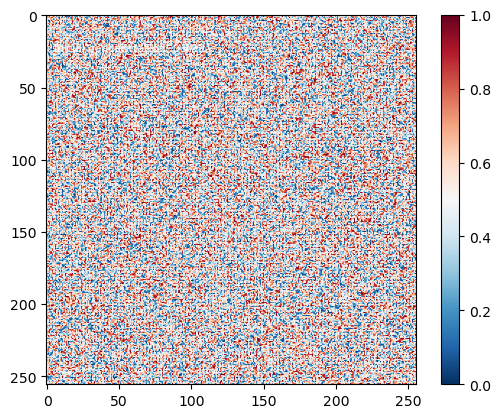

In [3]:
# Function to get the right-hand side of the PDE in Fourier space
def get_rhs(c, c_k, K2):
    f_prime = 2 * W * c * (1 - c) * (1 - 2 * c)
    dfdc_hat = fft2(f_prime)
    return -M * K2 * (dfdc_hat - kappa * K2 * c_k)

# Time-stepping loop
for _ in range(Nsteps):
    if len(prev_steps) < 4:
        # Use RK4 for the first four steps
        k1 = dt * get_rhs(c, c_k, K2)
        k2 = dt * get_rhs(np.real(ifft2(c_k + 0.5 * k1)), fft2(np.real(ifft2(c_k + 0.5 * k1))), K2)
        k3 = dt * get_rhs(np.real(ifft2(c_k + 0.5 * k2)), fft2(np.real(ifft2(c_k + 0.5 * k2))), K2)
        k4 = dt * get_rhs(np.real(ifft2(c_k + k3)), fft2(np.real(ifft2(c_k + k3))), K2)
        c_k += (k1 + 2 * k2 + 2 * k3 + k4) / 6
    else:
        # Use Adams-Moulton for subsequent steps
        rhs_prev = [get_rhs(c, ck, K2) for c, ck in prev_steps[-4:]]
        lhs_term = 1 - 251 * dt * M * kappa * K2 / 720
        rhs_term = fft2(prev_steps[-1][0]) + dt / 720 * (646 * rhs_prev[-1] - 264 * rhs_prev[-2] + 106 * rhs_prev[-3] - 19 * rhs_prev[-4])
        c_k = rhs_term / lhs_term

    c = np.real(ifft2(c_k))
    c = np.clip(c, 0.0, 1.0)
    c_history.append(c.copy())
    prev_steps.append((c, c_k))

    if len(prev_steps) > 4:
        prev_steps.pop(0)

# Animation
fig, ax = plt.subplots()
im = ax.imshow(c_history[0], cmap='RdBu_r', vmin=0.0, vmax=1.0)
cb = plt.colorbar(im, ax=ax)

time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color="black", fontsize=8)
initial_concentration_text = ax.text(0.02, 0.90, f'Initial concentration: {c0:.3f}', transform=ax.transAxes, color="white", fontsize=8)
#ax.set_title('Cahn-Hilliard Evolution')
plt.savefig('cahn-hilliard-c0-%.1f.png'% c0)

In [ ]:

def update(num):
    im.set_array(c_history[num])
    
    #time_text.set_text()
    ax.set_title(f'c0 = {c0}, t = {num * dt:.3f}')
    return fig,
def animate(i):
    im.set_data(c[ i])
    im.set_clim(0.0, 1.0)
    tx.set_text('t={:.1f}'.format(5 * i * dt))
    return fig,
ani = FuncAnimation(fig, update, frames=Nsteps, interval=200, blit=True)
#ani = animation.FuncAnimation(fig, animate, frames=Nsteps, blit=True, repeat=False)
ani.save('cahn-hilliard_high_order2.gif', writer='pillow', fps=24, dpi=100)
plt.show()